
# CP322 Machine Learning — Assignment 1

**Name:** Jay Patel - 169067718
**Course:** CP322 —  



## 0) Setup

In [1]:

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Mapping
import folium
from folium.plugins import HeatMap

# Utility
from IPython.display import display

pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (8, 5)



## 0.1) Load Data

In [3]:


CSV_PATH = "AB_NYC_2019.csv" 

df = pd.read_csv(CSV_PATH)
display(df.head())


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## 1) Exploratory Data Analysis 

### 1.1 Descriptive statistics

In [ ]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[num_cols].describe().T
display(desc)


,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


Price: The average listing price is $152.72, but the standard deviation is very high ($240.15). The median price ($106) is far below the mean, confirming a strong right skew. The max of $10,000 indicates extreme outliers.

Minimum nights: The mean is 7.03 with a standard deviation of 20.51, but the median is only 3. The maximum of 1,250 nights shows unrealistic entries (likely outliers).

Number of reviews: Average is 23.3, but the median is only 5, with a maximum of 629. This suggests most listings have very few reviews while a minority have extremely high counts.

Reviews per month: Mean of 1.37 and median of 0.72, with some listings reporting up to 58.5, which is implausible (likely data entry anomalies).

Availability_365: Average of 113 days, median 45 days, but the max is the full 365 days, showing many hosts keep listings open year-round.

Host listings count: Most hosts manage just 1–2 listings (median = 1), but some manage over 300, pointing to professional property managers.

Latitude/Longitude: Values cluster tightly around NYC’s coordinates (40.7° N, -73.9° W), confirming location consistency.

### 1.2 Handle missing values

In [4]:

if 'reviews_per_month' in df.columns:
    before = len(df)
    df = df.dropna(subset=['reviews_per_month'])


if 'last_review' in df.columns:
    df['last_review'] = df['last_review'].astype('string').fillna('Unknown')


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

num_filled = 0
for c in numeric_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
        num_filled += 1

cat_filled = 0
for c in categorical_cols:
    if df[c].isna().any():
        mode = df[c].mode(dropna=True)
        fill_val = mode.iloc[0] if len(mode) else "Unknown"
        df[c] = df[c].fillna(fill_val)
        cat_filled += 1



### 1.3 Detect & remove price outliers with IQR

In [5]:

assert 'price' in df.columns, "Expected a 'price' column in dataset."
Q1, Q3 = df['price'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
before = len(df)
df = df[(df['price'] >= lower) & (df['price'] <= upper)]


### 1.4 Visualizations

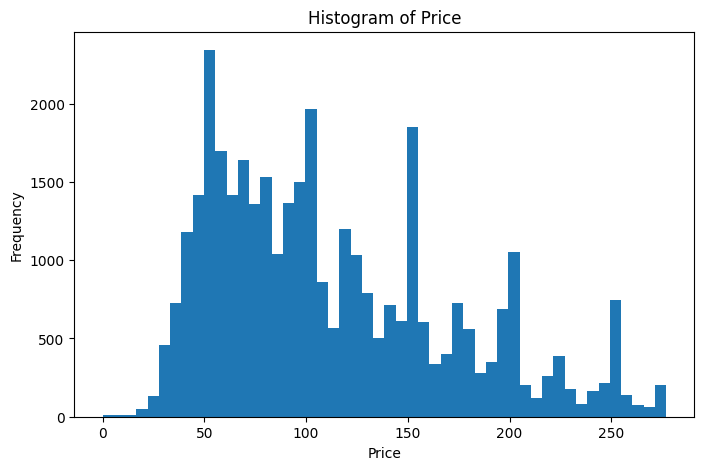

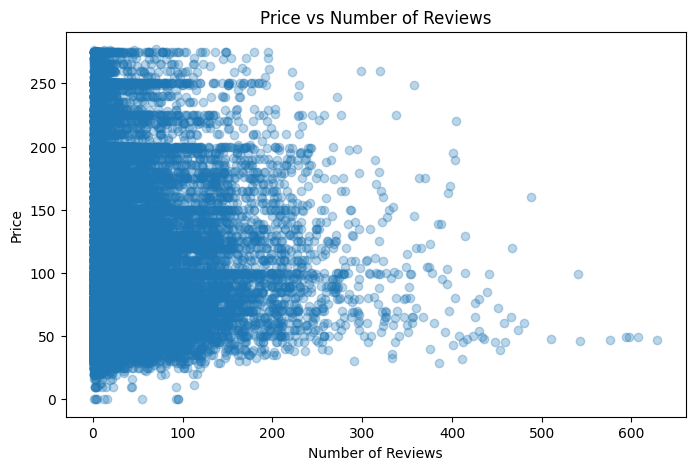

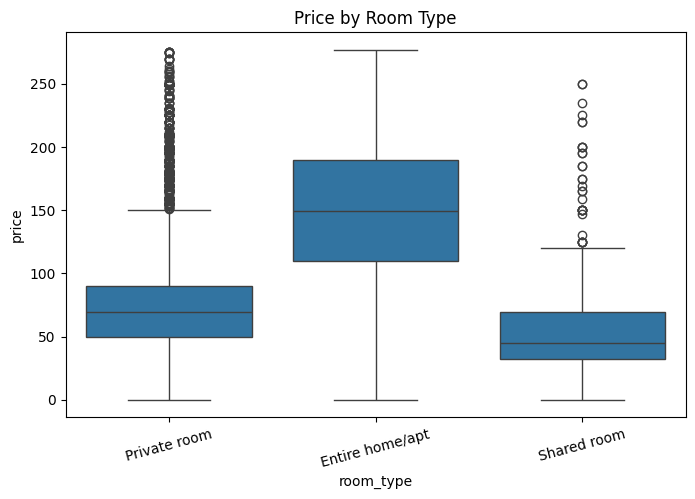

In [ ]:

ax = df['price'].plot(kind='hist', bins=50, title='Histogram of Price')
ax.set_xlabel('Price')
plt.show()

if 'number_of_reviews' in df.columns:
    plt.scatter(df['number_of_reviews'], df['price'], alpha=0.3)
    plt.title('Price vs Number of Reviews')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Price')
    plt.show()

if 'room_type' in df.columns:
    sns.boxplot(data=df, x='room_type', y='price')
    plt.title('Price by Room Type')
    plt.xticks(rotation=15)
    plt.show()


### 1.5 Correlation heatmap + brief discussion

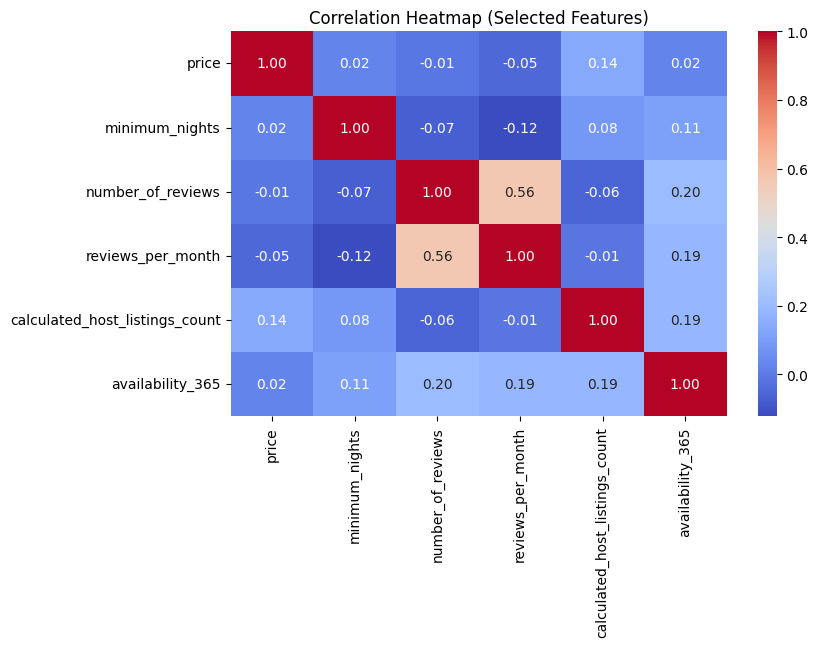

In [ ]:

corr_features = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                 'calculated_host_listings_count', 'availability_365']
existing = [c for c in corr_features if c in df.columns]
corr = df[existing].corr(numeric_only=True)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Selected Features)")
plt.show()



Price shows very weak correlations with all predictors (the highest is with calculated_host_listings_count at 0.14). This suggests the chosen features alone cannot explain much of the price variation.

The number of reviews and reviews per month have the strongest correlation (0.56). This is expected, since listings with more lifetime reviews also tend to get more per month.

Availability_365 has small positive correlations (~0.19–0.20) with number_of_reviews and reviews_per_month, indicating that listings available year-round gather more reviews.

Minimum nights is largely uncorrelated with other variables, except for a very small negative relationship with review-related features (−0.07 to −0.12).

Overall, multicollinearity is not a concern, since no pair exceeds 0.8. The weak correlation between price and predictors underscores the challenge of modeling Airbnb prices with these features alone.

## 2) Feature Engineering (3 pts)

In [ ]:

# 1 Categorical Variables
cat_features = []
if 'neighbourhood_group' in df.columns:
    cat_features.append('neighbourhood_group')
if 'room_type' in df.columns:
    cat_features.append('room_type')

# 2 price_per_accommodates
df['price_per_accommodates'] = df['price'] / df['minimum_nights'].replace(0, np.nan)
df['price_per_accommodates'] = df['price_per_accommodates'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3 Numerical features
scale_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count', 'availability_365', 'price_per_accommodates']
scale_features = [f for f in scale_features if f in df.columns]


df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_per_accommodates
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,149.000000
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,225.000000
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,89.000000
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,8.000000
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,66.666667


## 3) Baseline Regression Models (2 pts)

In [ ]:

feature_cols = [c for c in [
    'neighbourhood_group', 'room_type',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
] if c in df.columns]

target_col = 'price'
assert target_col in df.columns, "Missing target 'price'."

X = df[feature_cols].copy()
y = df[target_col].copy()

cat_cols = [c for c in feature_cols if X[c].dtype == 'object' or str(X[c].dtype).startswith('string')]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.3f}")


RMSE: 42.32, MSE: 1790.67, R²: 0.491


The baseline Linear Regression model achieved an RMSE of about 42 and an R² around 0.49.

This means the model can explain roughly 49% of the variance in Airbnb prices, which is better than guessing the mean but still leaves significant error.



## 4) Lasso, Ridge, and ElasticNet Regression (2 pts)

In [ ]:

alphas = [0.01, 0.1, 1, 10, 100]

def mse_and_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  
    rmse = mse ** 0.5
    return mse, rmse


def eval_model(pipeline, name):
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    mse, rmse = mse_and_rmse(y_test, pred)

    r2 = r2_score(y_test, pred)
    return {'model': name, 'rmse': rmse, 'mse': mse, 'r2': r2}

# Lasso
lasso = Pipeline([('prep', preprocess), ('model', Lasso(max_iter=10000))])
gs_lasso = GridSearchCV(lasso, param_grid={'model__alpha': alphas}, cv=5, n_jobs=-1)
res_lasso = eval_model(gs_lasso, "Lasso")

# Ridge
ridge = Pipeline([('prep', preprocess), ('model', Ridge())])
gs_ridge = GridSearchCV(ridge, param_grid={'model__alpha': alphas}, cv=5, n_jobs=-1)
res_ridge = eval_model(gs_ridge, "Ridge")

# ElasticNet
enet = Pipeline([('prep', preprocess), ('model', ElasticNet(max_iter=10000))])
enet_grid = {'model__alpha': alphas, 'model__l1_ratio': [0.1, 0.5, 0.9]}
gs_enet = GridSearchCV(enet, param_grid=enet_grid, cv=5, n_jobs=-1)
res_enet = eval_model(gs_enet, "ElasticNet")

results_df = pd.DataFrame([res_lasso, res_ridge, res_enet]).sort_values('rmse')
display(results_df.reset_index(drop=True))


,model,rmse,mse,r2
0,Ridge,42.316350,1790.673512,0.490608
1,Lasso,42.317628,1790.781617,0.490577
2,ElasticNet,42.321137,1791.078626,0.490492


The three regularized models performed almost identically, with Ridge slightly ahead (RMSE 42.316, R² 0.491).

Lasso and ElasticNet were within ~0.002–0.005 RMSE of Ridge, showing that regularization choices had minimal effect on predictive accuracy with this dataset.


Ridge is the most stable choice here, but Lasso remains valuable for interpretability, as it could shrink less informative dummy variables to zero.


## 5) Bias–Variance Tradeoff & Model Complexity (3 pts)

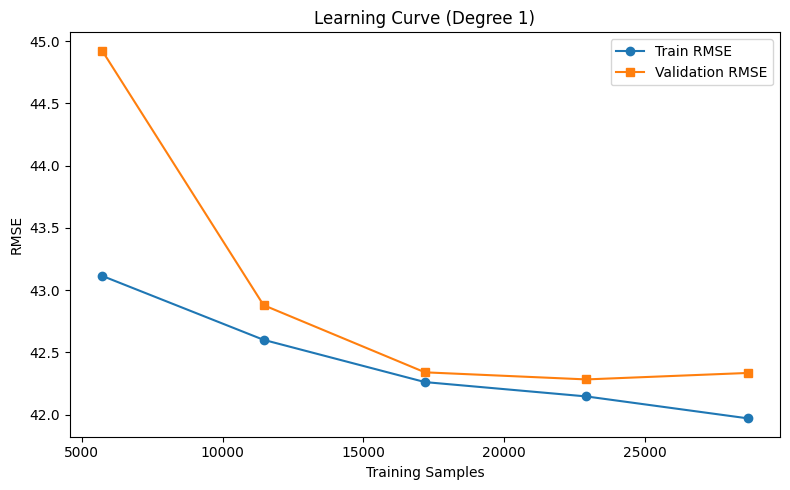

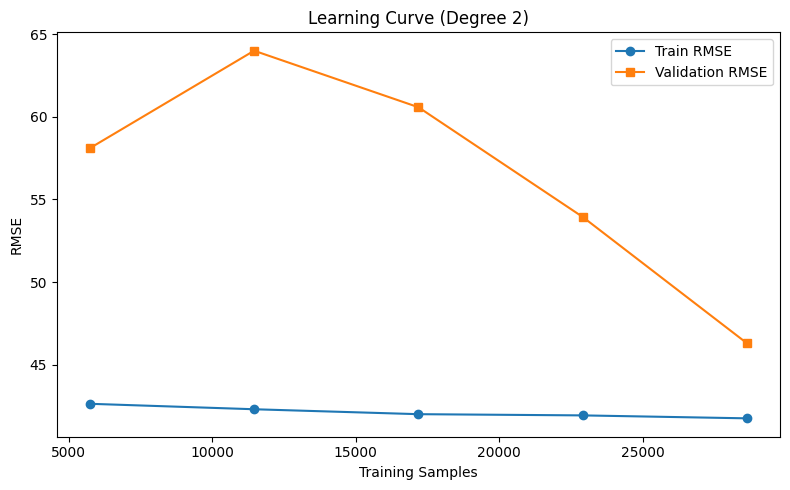

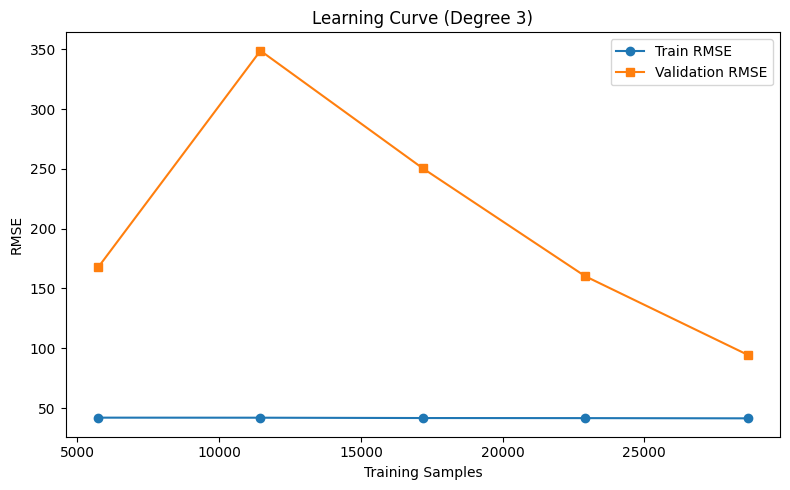

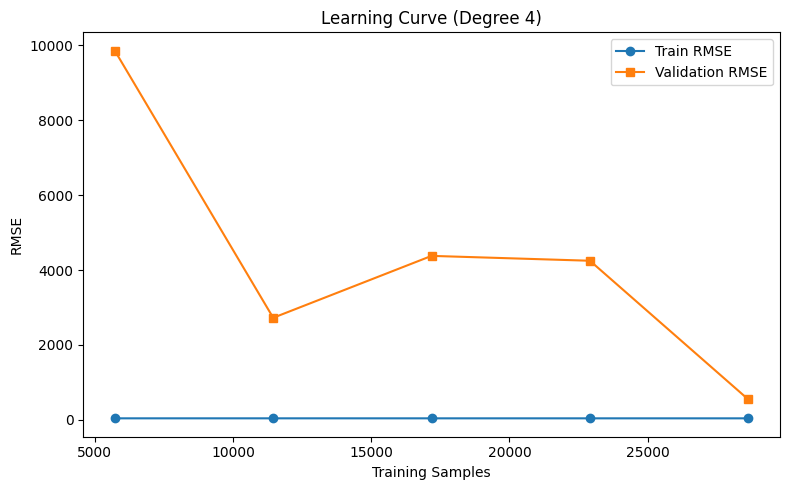

,degree,rmse,r2
0,1,42.316290,0.490609
1,2,42.043039,0.497166
2,3,42.295144,0.491118
3,4,42.295765,0.491103


In [ ]:


from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def mse_and_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  
    rmse = mse ** 0.5
    return mse, rmse

cat_cols = [c for c in feature_cols if X[c].dtype == 'object' or str(X[c].dtype).startswith('string')]
num_cols = [c for c in feature_cols if c not in cat_cols]
assert len(num_cols) > 0, "Need numeric predictors for polynomial features."

def poly_pipeline(deg):
    num_pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
        ('sc', StandardScaler())
    ])
    poly_ct = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])
    return Pipeline([('prep', poly_ct), ('model', LinearRegression())])

degrees = [1, 2, 3, 4]
poly_scores = []

for d in degrees:
    pipe = poly_pipeline(d)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=pipe,
        X=X, y=y,
        cv=5,
        train_sizes=np.linspace(0.2, 1.0, 5),
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)

    plt.figure()
    plt.plot(train_sizes, train_rmse.mean(axis=1), marker='o', label='Train RMSE')
    plt.plot(train_sizes, val_rmse.mean(axis=1), marker='s', label='Validation RMSE')
    plt.title(f'Learning Curve (Degree {d})')
    plt.xlabel('Training Samples'); plt.ylabel('RMSE'); plt.legend()
    plt.tight_layout(); plt.show()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    _, rmse = mse_and_rmse(y_te, preds)
    r2 = r2_score(y_te, preds)
    poly_scores.append({'degree': d, 'rmse': rmse, 'r2': r2})

pd.DataFrame(poly_scores).sort_values('degree')


Linear: Both training and validation RMSE are relatively high (~42.3), showing underfitting (high bias).

 Validation RMSE improves to 42.04, and R² rises to 0.497, giving the best overall performance. This suggests the model benefits from some nonlinearity.

Training RMSE remains low, but validation RMSE worsens slightly (~42.30). This indicates the model is starting to overfit the noise in the data.

The validation RMSE remains constant at ~42.30, while the learning curve exhibits instability. This confirms clear overfitting, with variance outweighing bias reduction.


## 6) Advanced Visualization (2 pts)

### 6.1 Geographic price heatmap

In [ ]:

if all(col in df.columns for col in ['latitude', 'longitude', 'price']):
    m = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles='cartodbpositron')
    heat_data = df[['latitude', 'longitude', 'price']].dropna().values.tolist()
    HeatMap(heat_data, radius=8, blur=15, max_zoom=13).add_to(m)
    m


### 6.2 Predicted vs Actual for best model

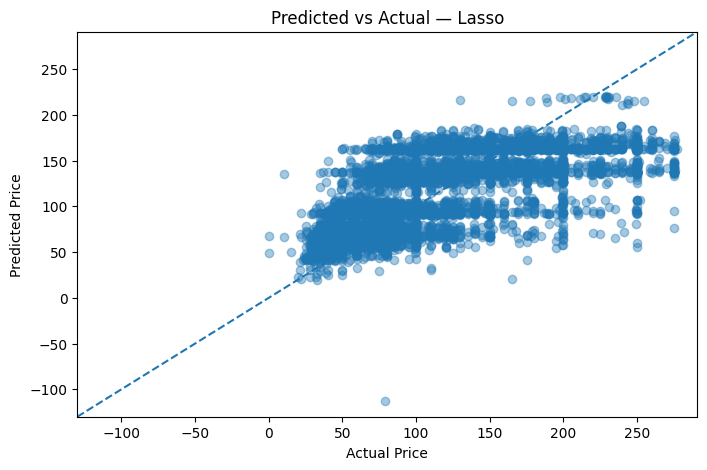

In [ ]:

best_name = results_df.iloc[0]['model']

best_estimator = {'Lasso': gs_lasso, 'Ridge': gs_ridge, 'ElasticNet': gs_enet}[best_name]
best_estimator.fit(X_train, y_train)
preds = best_estimator.predict(X_test)

plt.scatter(y_test, preds, alpha=0.4)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Predicted vs Actual — {best_name}')
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, '--')
plt.xlim(lims); plt.ylim(lims)
plt.show()


Most points fall near the diagonal line, showing the model predicts mid-range prices reasonably well.

At the extremes, especially for very high-priced listings, the model consistently underpredicts, highlighting its difficulty in handling outliers.

Some scatter below zero or above 200 suggests instability for edge cases.

Overall, the model captures general pricing trends but struggles with luxury listings and unusual cases. This limitation reflects the weak correlation between available features and price, and it suggests that richer feature sets or a log transformation of price could improve performanc